<a href="https://colab.research.google.com/github/spaceml-org/Missing-Pixel-Filler/blob/main/swathfiller_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing Pixel Filler

This is the official code example for the [**Missing Pixel Filler**](https://arxiv.org/abs/2106.07113) by [SpaceML](http://spaceml.org/).

# Introduction

`missing-pixel-filler` is a python package that, given images that may contain missing data regions (like satellite imagery with swath gaps), returns these images with the regions filled. These regions of missing data are filled using a dynamic method that incorporates randomly chosen, non-null neighboring pixels. The missing data filling algorithms can be changed according to user preferences.

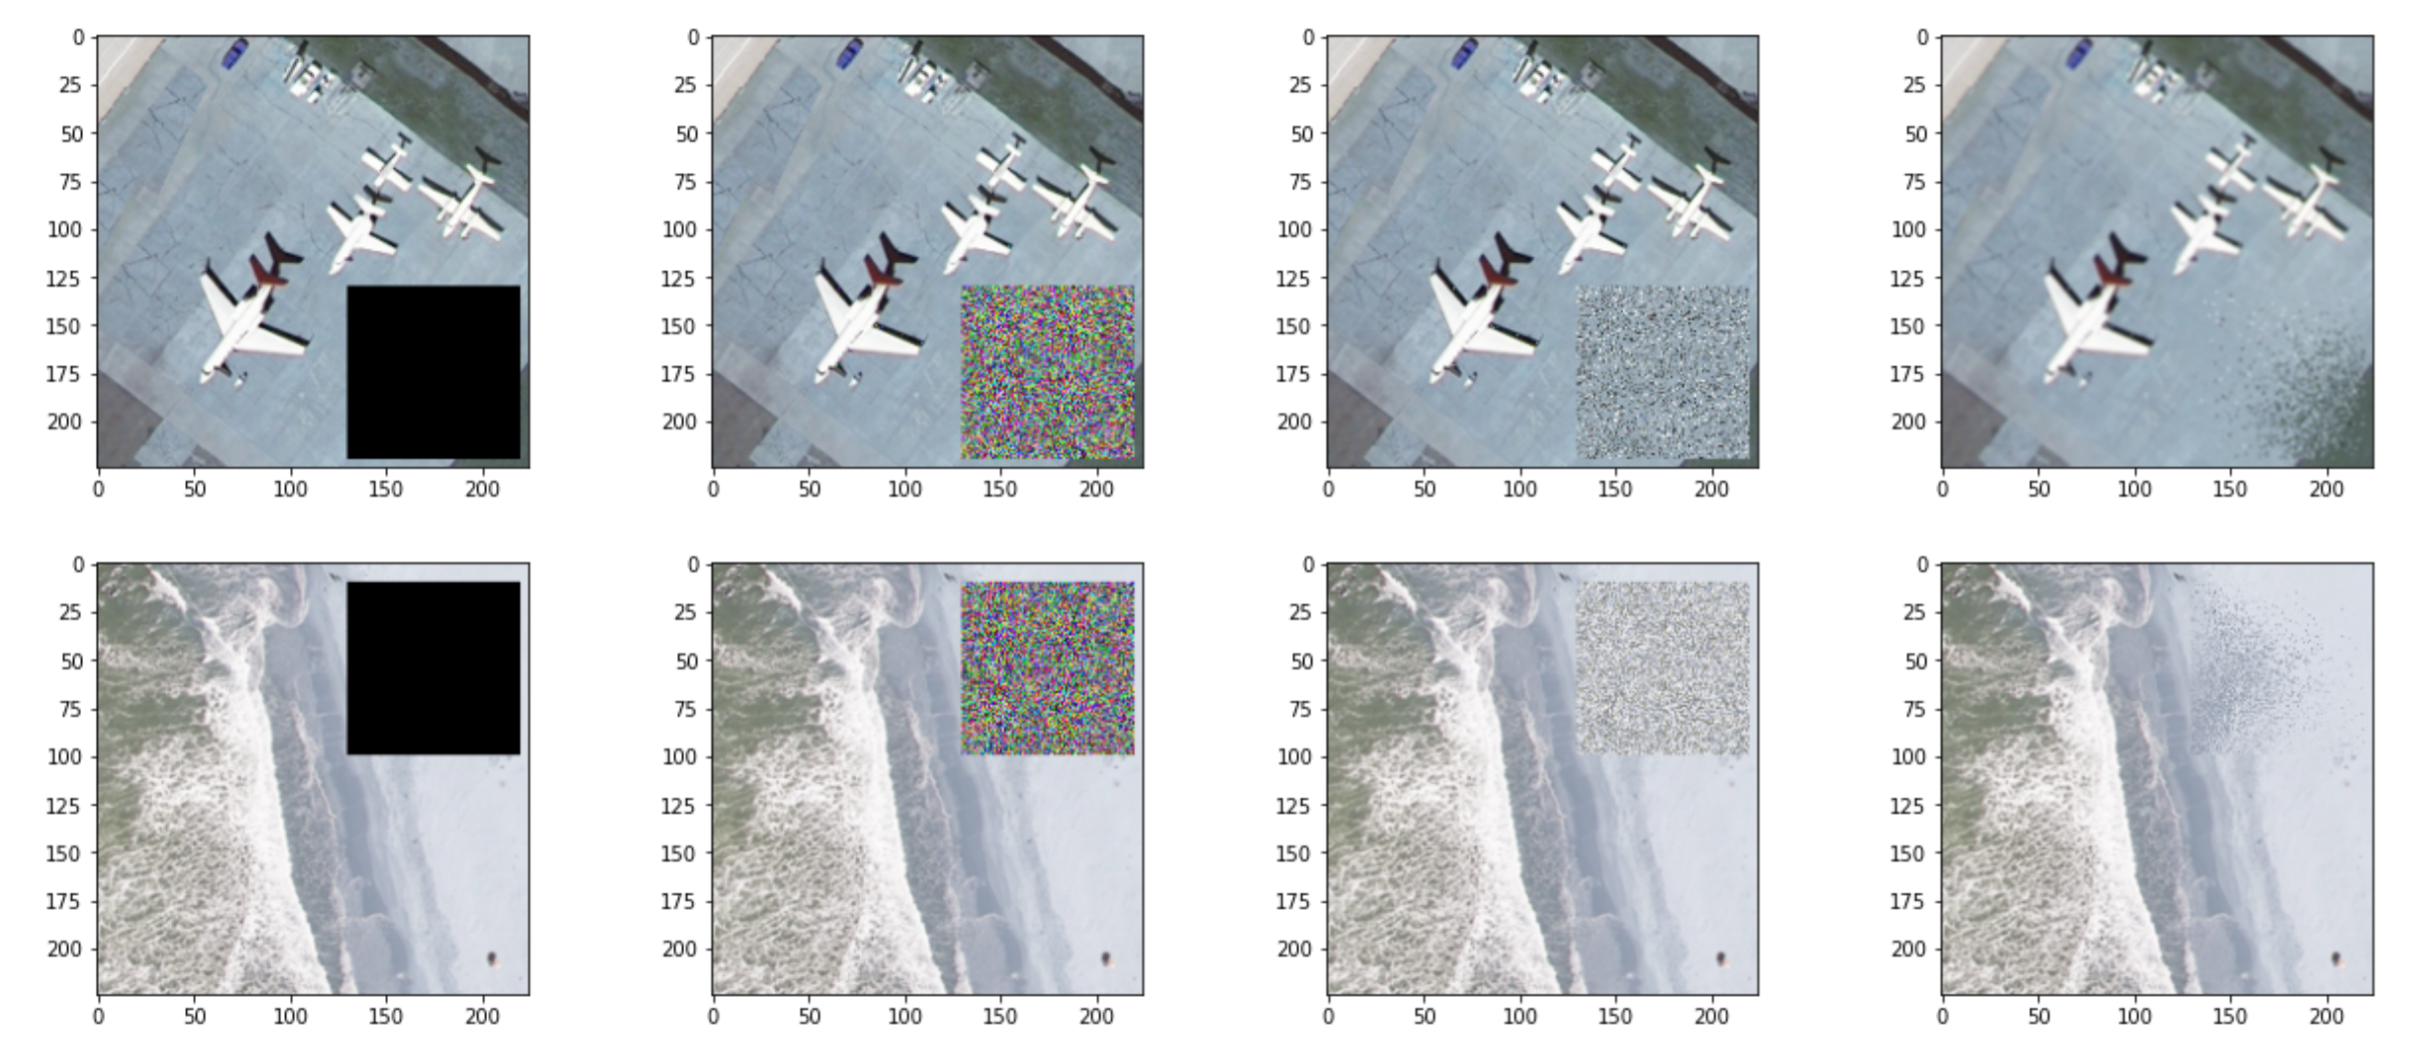

### Motivation
In unsupervised machine learning models, labels are not present in the image dataset, giving no standard "guideline" for the model metric for the model to compare against. Therefore, missing portions of an image may attract significant undesireable attention of the model, i.e. lead the model to "learn" patterns of the missing pixels rather than the image's actual (non-missing) contents. Due to this, many images containing missing pixel images are currently discarded or rendered unusable for training unsupervised models. 

Earth Science, as well as many other domains, rely on the use of imagery data to train machine learning models. For instance, feeding a model large amounts of consistent hurricane imagery is prerequisite to training a good model to automatically detect hurricanes. 

However, NASA's MODIS satellites Terra and Aqua, which provide the imagery for NASA [Worldview](https://worldview.earthdata.nasa.gov/), has missing data in spindle-shaped gaps near the equator, due to the constant nature of satellite bandwidths not being sufficient to cover the Earth's large surface area in the equatorial area. Continuing with our hurricane example, this means that many hurricane images captured near the equator would be rendered unusable, due to having some portion overlapping one of these black missing image areas. 

More information on our work with this package can be found [on Arxiv](https://arxiv.org/abs/2106.07113), or [GitHub](https://github.com/spaceml-org/Missing-Pixel-Filler).


Our filling methods 

Figure 1: NASA MoODIS Sswath Gaps
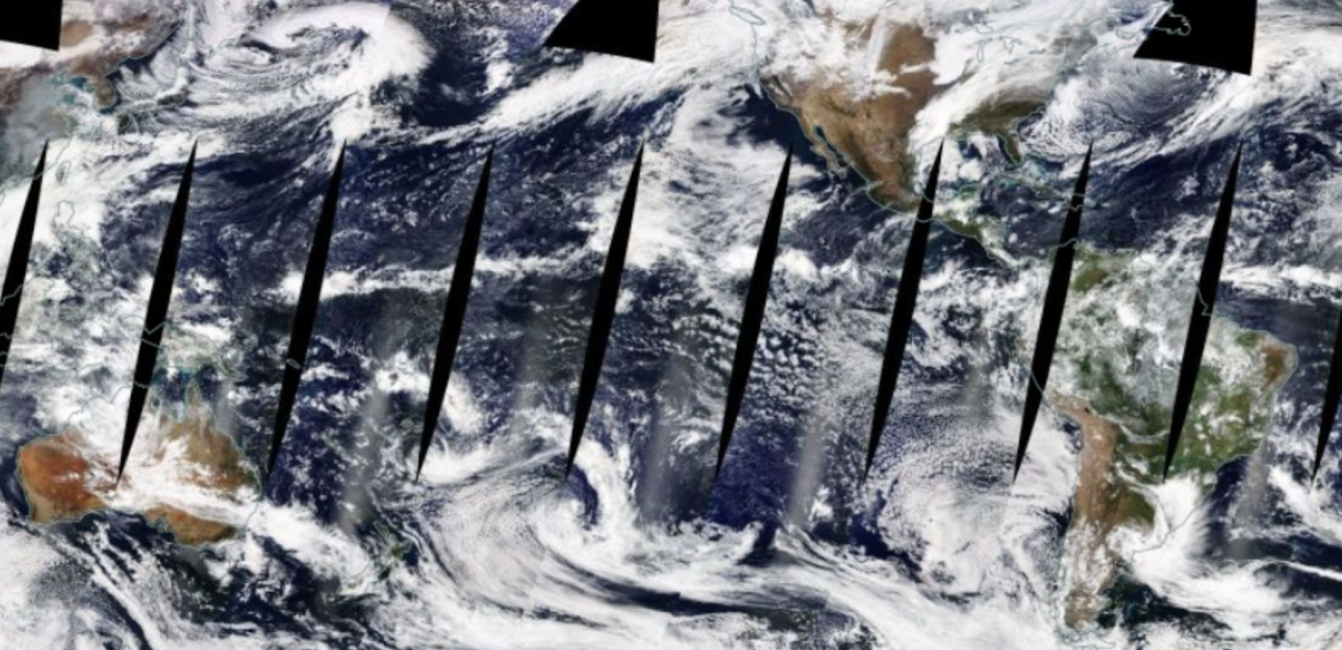

### Filling Methods
We propose 3 distinct policies of increasing effectiveness with which to fill the missing data, respectively, and illustrate using this example swath gap synthesized from the UC Merced LandUse Datset: 

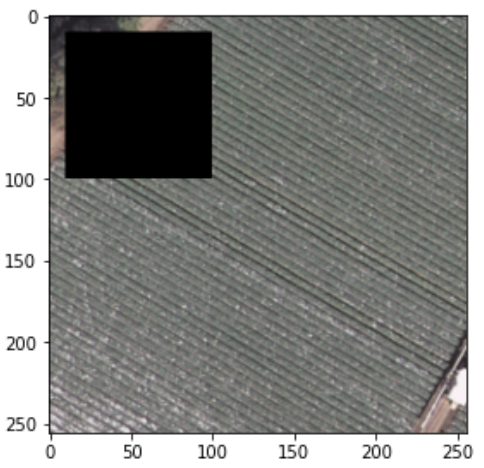


1.   Random RGB: Random pixel selected from uniform Gaussian distribution
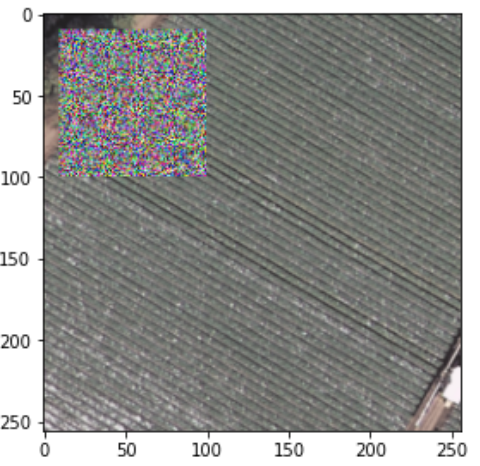
2.   Random Pixel: Random pixel selected from non-missing portion of the image
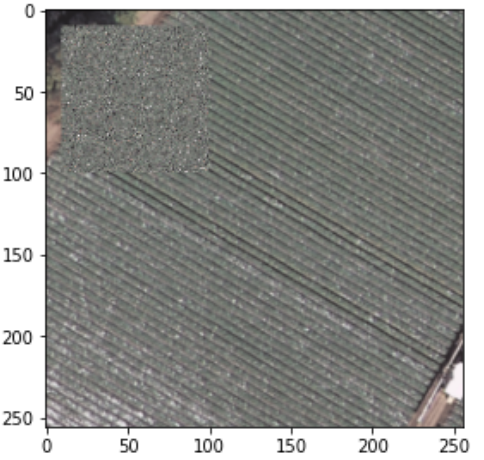
3.   Neighbor Pixel: Pixel selected from weighted distribution of non-missing image, with pixels nearer to the missing pixel of interest having higher probability of selection. 

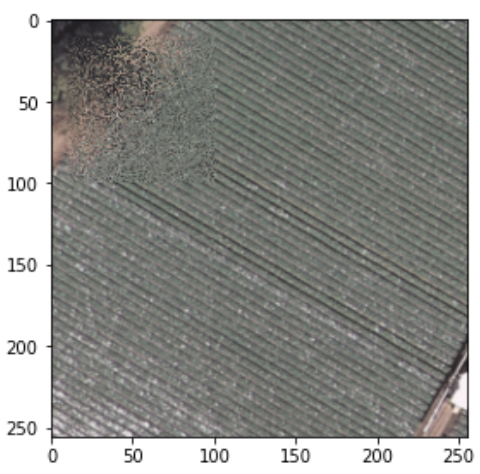

# Try it yourself!

....you can try on your own image or use an example image from uc merced ...

### Imports

In [ ]:
import math
import random 
import PIL
from PIL import Image, ImageDraw
import numpy as np
from itertools import chain
import cv2
from matplotlib import pyplot as plt
import subprocess
import threading 
import sys
from os import path
from statistics import mean
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

import os


# Functions

In [ ]:
# Random seed
random.seed(1337)

### Generate swath in top-left, bottom-left, top-right, and bottom-right positions

In [ ]:
# Updated:
# input: img (numpy array)
# output: image_with_swath (numpy array), swath parameters

x = len(img[0])
y = len(img)

def generate_swath_top_left(img):
  swath_img = img.copy()
  swath_img[10:100, 10:100] = 0
  return swath_img

def generate_swath_bottom_left(img):
  swath_img = img.copy()
  swath_img[130:220, 10:100] = 0
  return swath_img

def generate_swath_top_right(img):
  swath_img = img.copy()
  swath_img[10:100, 130:220] = 0
  return swath_img

def generate_swath_bottom_right(img):
  swath_img = img.copy()
  swath_img[130:220, 130:220] = 0
  return swath_img

def generate_random_swath(img):
  # resize image to 224 by 224
  image_with_swath = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  img_area = 224 * 224

  rand = random.randint(1, 4)

  print(rand)

  img_with_swath = img
  if rand == 1:
    img_with_swath = generate_swath_top_left(img_with_swath)
  elif rand == 2:
    img_with_swath = generate_swath_top_right(img_with_swath)
  elif rand == 3:
    img_with_swath = generate_swath_bottom_left(img_with_swath)
  elif rand == 4:
    img_with_swath = generate_swath_bottom_right(img_with_swath)

  return img_with_swath
  

### 1. Fill with Random RGB
Uniformily selected pixel values from a Gaussian distribution

In [ ]:
# input: img (np array)
# output: arr (np array with swath filled by random RGB)
def fill_swath_with_random_rgb(img, color=[0,0,0]):
  arr = img.copy()
  x, y, z = np.where(arr==color)
  for i in range(len(x)):
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    arr[x[i]][y[i]]=color
  return arr

### 2. Fill with Random Pixel
Uniformly selected pixel values from image (non-missing) background


In [ ]:
# input: x_arr (non-swath x coords), y_arr (non-swath y coords)
# output: a random non-swath pixel
def get_random_pixel_from_image(x_arr, y_arr):
  index = random.randint(0, len(x_arr)-1)
  return x_arr[index], y_arr[index]

# input: img (np array)
# output: img (np array with random other pixels from image)
def fill_swath_with_random_pixel_from_image_new(img, color=[0,0,0]):
  img = img.copy()
  (x_non_swath, y_non_swath, z_non_swath) = np.where(img != color)
  (x_swath, y_swath, z_swath) = np.where(img == color)
  for i in range(len(x_swath)):
    x_pixel, y_pixel = get_random_pixel_from_image(x_non_swath, y_non_swath)
    img[x_swath[i]][y_swath[i]] = img[x_pixel][y_pixel]

  return img

### 3. Fill with Neighbor Pixel
Select pixel values from surrounding image pixels, with likelihood of selection proportional to distance from pixel of interest

In [ ]:
# Dynamically tries finding non empty points in neighbourhood
# When it fails few times, it increases neighbourhood size automatically
def get_neighboring_pixel(img, x, y):
  x_rand, y_rand = 0,0

  max_num_tries = 30
  max_tries_per_neighbourhood = 3
  neighbourhood_size_increment = 10
  current_window_size = 10
  total_tries = 0
  for _ in range(math.ceil(max_num_tries/max_tries_per_neighbourhood)):
    for _ in range(max_tries_per_neighbourhood):
      min_x = max(0, x-current_window_size)
      max_x = min(224, x+current_window_size)
      min_y = max(0, y-current_window_size)
      max_y = min(224, y+current_window_size)
      x_rand = random.randint(min_x, max_x-1)
      y_rand = random.randint(min_y, max_y-1)
      total_tries += 1
      if not(img[x_rand][y_rand][0]==0 and img[x_rand][y_rand][1]==0 and img[x_rand][y_rand][2]==0):
        return x_rand, y_rand
    current_window_size += neighbourhood_size_increment

  return x_rand, y_rand
    
def fill_swath_with_neighboring_pixel(img):
  img_with_neighbor_filled = img.copy()
  (x_swath, y_swath, z_swath) = np.where(img == [0, 0, 0])

  for i in range(len(x_swath)):
    x_rand, y_rand = get_neighboring_pixel(img, x_swath[i], y_swath[i])
    img_with_neighbor_filled[x_swath[i]][y_swath[i]] = img[x_rand][y_rand]
  return img_with_neighbor_filled

# Test an image

### Option 1: Upload an image


In [ ]:
from google.colab import files
uploaded = files.upload()

# DELETE
# items = os.listdir(os.getcwd())
# for each_image in items:
#   if each_image.endswith(".jpg") or each_image.endswith(".png"):
#     full_path = "/content/" + each_image
# image = Image.open(full_path)

In [ ]:
image = Image.open('__YOUR IMAGE NAME__')
img = np.asarray(image)

### Option 2: Use a sample image from UC Merced LandUse Dataset

In [ ]:
def get_ucmerced_dataset():
  !wget https://www.dropbox.com/s/daryz3bbhvrrvd5/UCMerced_LandUse.zip
  !unzip -q UCMerced_LandUse.zip
  !rm '/content/UCMerced_LandUse.zip'

get_ucmerced_dataset()

# Replace path with an image of choice
image = Image.open('/content/UCMerced_LandUse/Images/agricultural/agricultural00.tif')
img = np.asarray(image)
plt.imshow(image)

### Visualize Results

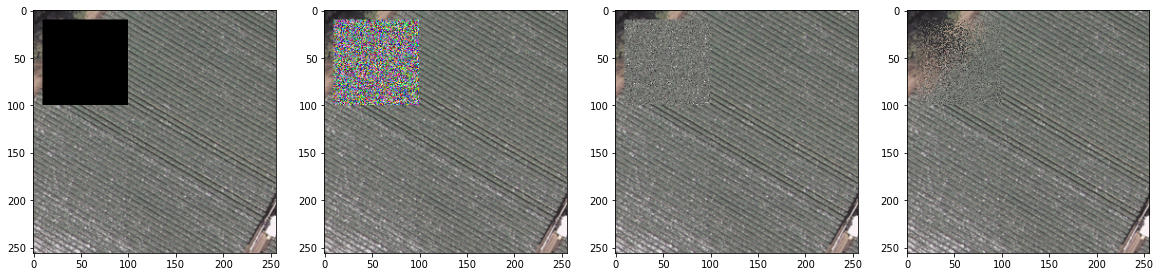

In [ ]:
# Visualize results
swath = generate_swath_top_left(img)

randomfill = fill_swath_with_random_rgb(swath)
pixelfill = fill_swath_with_random_pixel_from_image_new(swath)
neighborfill = fill_swath_with_neighboring_pixel(swath)

fig, ax = plt.subplots(1, 4, figsize = (20, 20))
ax[0].imshow(swath)
ax[1].imshow(randomfill)
ax[2].imshow(pixelfill)
ax[3].imshow(neighborfill)


Please cite us if you use our code:
```
@article{cao2020swathgaps,
  title={Reducing Effects of Swath Gaps in Unsupervised Machine Learning},
  author={Chen, Sarah and Cao, Esther and Koul, Anirudh and Ganju, Siddha and Praveen, Satyarth and Kasam, Meher Anand},
  journal={Committee on Space Research Machine Learning for Space Sciences Workshop},
  year={2021}
}
```